In [1]:
import time
import sys
import os
import numpy as np
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from measurement.magneticresonance import pODMR, Rabi

from measurement.task_base import JobManager
import atexit
jm = JobManager()
def release_lock():
    return jm.stop()
atexit.register(release_lock)

<function __main__.release_lock()>

In [2]:
# load the hardware manager
# # add some devices to the server (if they aren't already added) ##################################################
import hardware.config_custom as hcf
from hardware.hardwaremanager import HardwareManager
from pathlib import Path
inserv = HardwareManager()
HERE = Path(path_project)
# pulse generator
try:
    inserv.add(
        'pg', 
        HERE / 'hardware' / 'pulser' / 'pulser.py', 
        'PulseGenerator', 
        [],
        dict(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=hcf.PS_choffs), 
    )
except Exception as ee:
    print(ee)

# mw signal generator
try:
    inserv.add(
        'mwsyn', 
        HERE / 'hardware' / 'mw' / 'mwsynthesizer.py', 
        'Synthesizer', 
        [hcf.VDISYN_SN], 
        dict(vidpid=hcf.VDISYN_VIDPID,
            baudrate=hcf.VDISYN_BAUD, 
            timeout=5, 
            write_timeout=5)
    )
except Exception as ee:
    print(ee)

# laser
try:
    inserv.add(
            'laser', 
            HERE / 'hardware' / 'laser' / 'laser.py', 
            'LaserControl', 
            [hcf.LASER_SN]
        )
except Exception as ee:
    print(ee)

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [63]:
podmr = pODMR()
stoptime = 100 # seconds
podmr.set_stoptime(stoptime) 
podmr.set_priority(10)
f_NVguess = 398.545
podmr.set_paraset(
    freq_start = (f_NVguess-0.04),
    freq_stop = (f_NVguess+0.04),
    freq_step = 0.2E-3,
    # init_laser = 1500.0,
    init_wait = 401.0,
    init_nslaser = 4.0,
    init_isc = 200,
    init_repeat = 20,
    mw_time = 2000.0,
    read_wait = 500.0,
    read_laser = 1201.0,
    mw_powervolt = 5.0,
    laser_current = 91.26, #0 to 100%
    min_volt = -0.002, # [V]
    max_volt = 0.060,
)

In [64]:
jm.start()
jm.submit(podmr)
# podmr.pause()

In [65]:
time.sleep(stoptime+8)
filename = podmr.get_backup_filename()
from measurement.task_base import load_instance
print(f"Class object (orginal) {podmr}")
jjodmr = load_instance(filename)
print(f"Class object (load from outside) {jjodmr}")
print(f"  same same? {jjodmr is podmr}")

Class object (orginal) <measurement.magneticresonance.pODMR object at 0x0000015DF5EB3970>
Class object (load from outside) <measurement.magneticresonance.pODMR object at 0x0000015DF5EB3970>
  same same? True


In [66]:
bbodmr = pODMR(name="bbgood")
print(f"Class object (different one) {bbodmr}")
print(f"  same same? {bbodmr is podmr}")
bbodmr.load(filename)
print(f"Class object (reload) {bbodmr}")
print(f"  reloaded properties? {bbodmr.dataset is podmr.dataset}")
print(f"  same same? {bbodmr is podmr}")

Class object (different one) <measurement.magneticresonance.pODMR object at 0x0000015DF6041BA0>
  same same? False
Class object (reload) <measurement.magneticresonance.pODMR object at 0x0000015DF6041BA0>
  reloaded properties? True
  same same? False


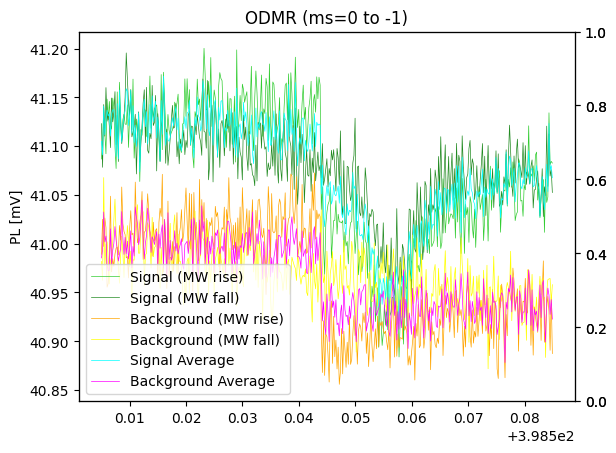

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
freq = jjodmr.dataset["freq"]
sig_rise = jjodmr.dataset["sig_mw_rise"]
sig_fall = jjodmr.dataset["sig_mw_fall"]
sig_av = (sig_rise+sig_fall)/2

bg_rise = jjodmr.dataset["sig_nomw_rise"]
bg_fall = jjodmr.dataset["sig_nomw_fall"]
bg_av = (bg_rise+bg_fall)/2

ax1.plot(freq, sig_rise*1E3, linewidth=0.5, label="Signal (MW rise)", color="limegreen")
ax1.plot(freq, sig_fall*1E3, linewidth=0.5, label="Signal (MW fall)", color="forestgreen")
ax1.plot(freq, bg_rise*1E3, linewidth=0.5, label="Background (MW rise)", color="orange")
ax1.plot(freq, bg_fall*1E3, linewidth=0.5, label="Background (MW fall)", color="yellow")
ax1.plot(freq, sig_av*1E3, linewidth=0.5, label="Signal Average", color="cyan")
ax1.plot(freq, bg_av*1E3, linewidth=0.5, label="Background Average", color="magenta")


# ax1.set_xlabel("Frequency [GHz]")
ax1.set_ylabel("PL [mV]")
# ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='lower left')
plt.title("ODMR (ms=0 to -1)")
plt.show()

Fitted Parameters and Uncertainties:
A (Amplitude): -115.234 ± 6.320 µV
f0 (Center Frequency): 398.5565 ± 0.0002 GHz
Gamma (HWHM): 4.022 ± 0.367 MHz
C (Flat background): 126.601 ± 1.725 µV


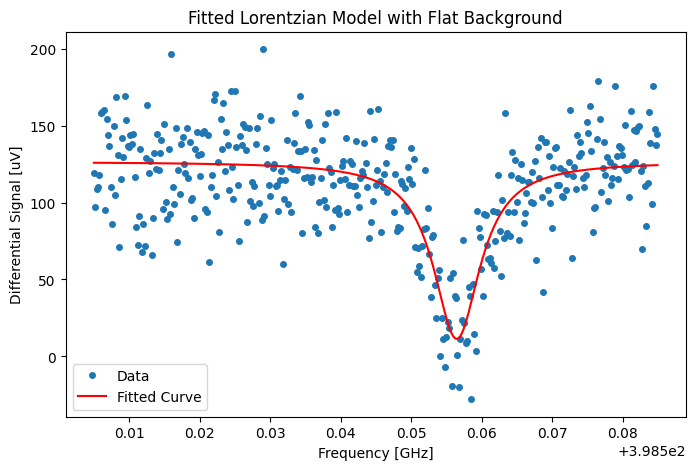

In [ ]:
sig_diff = sig_av-bg_av
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Lorentzian model with a flat background
def model_lorentzian(freq, A, f0, Gamma, C):
    """
    Lorentzian model with a flat background.
    :param freq: Frequency array
    :param A: Amplitude of the Lorentzian (can be positive or negative)
    :param f0: Center frequency
    :param Gamma: Half-width at half-maximum (HWHM)
    :param C: Flat background offset
    """
    return A * (Gamma**2 / ((freq - f0) ** 2 + Gamma**2)) + C


# Estimator for initial parameters
def estimator_lorentzian(freq, sig):
    """
    Estimate initial parameters for the Lorentzian model.
    :param freq: Frequency array
    :param sig: Signal array
    :return: Initial guesses for A, f0, Gamma, and C
    """
    # Estimate flat background (C) as the median of the signal
    C = np.median(sig)

    # Estimate amplitude (A) as the difference between the max and min signal
    A = np.max(sig) - np.min(sig)

    # Estimate center frequency (f0) as the frequency corresponding to the maximum absolute deviation
    f0 = freq[np.argmax(np.abs(sig - C))]

    # Estimate Gamma as the range where the signal drops to half the peak
    half_max = np.abs(A) / 2
    near_peak = np.abs(sig - C) > half_max
    if np.sum(near_peak) > 1:
        Gamma = (freq[near_peak][-1] - freq[near_peak][0]) / 2
    else:
        Gamma = (freq[-1] - freq[0]) / 10  # Default guess for Gamma

    return [A, f0, np.abs(Gamma), C]


# Fit the Lorentzian model
def fit_lorentzian(xx, yy):
    # Estimate initial parameters
    initial_guess = estimator_lorentzian(xx, yy)

    # Curve fitting
    params, covariance = curve_fit(model_lorentzian, xx, yy, p0=initial_guess)

    return params, np.sqrt(np.diag(covariance))  # Return parameters and uncertainties


# Example usage
# Assuming freq and sig_diff are your data arrays
params, uncertainties = fit_lorentzian(freq, sig_diff)

# Extract parameters
A, f0, Gamma, C = params
u_A, u_f0, u_Gamma, u_C = uncertainties

# Print fitted parameters with uncertainties
print("Fitted Parameters and Uncertainties:")
print(f"A (Amplitude): {A*1e6:.3f} ± {u_A*1e6:.3f} µV")
print(f"f0 (Center Frequency): {f0:.4f} ± {u_f0:.4f} GHz")
print(f"Gamma (HWHM): {Gamma*1e3:.3f} ± {u_Gamma*1e3:.3f} MHz")
print(f"C (Flat background): {C*1e6:.3f} ± {u_C*1e6:.3f} µV")

# Generate fitted curve
fitted_signal = model_lorentzian(freq, *params)

# Plot the original data and fitted curve
plt.figure(figsize=(8, 5))
plt.plot(freq, sig_diff*1e6, "o", label="Data", markersize=4)
plt.plot(freq, fitted_signal*1e6, "-", label="Fitted Curve", color="red")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Differential Signal [uV]")
plt.title("Fitted Lorentzian Model with Flat Background")
plt.legend()
plt.show()

In [24]:
rabi = Rabi()
stoptime = 40 # seconds
rabi.set_stoptime(stoptime) 
rabi.set_priority(9) 
rabi.set_paraset(
            laser_current = 90.05, # percentage 
            mw_freq = 398.556, # GHz 
            mw_powervolt = 5.0, # voltage 0.0 to 5.0 
            mw_phasevolt = 0.0, # voltage 0.0 to 5.0
            init_nslaser = 40, # [ns]
            init_isc = 150,
            init_repeat = 40,
            init_wait = 201.0,
            read_wait = 300.0,
            read_laser = 1201.0,
            mw_dur_begin = 10.0,
            mw_dur_end = 3500,
            mw_dur_step = 50.0,  
            max_volt = 0.060,
            min_volt = -0.005
)


In [25]:
jm.start()
jm.submit(rabi)
time.sleep(stoptime)

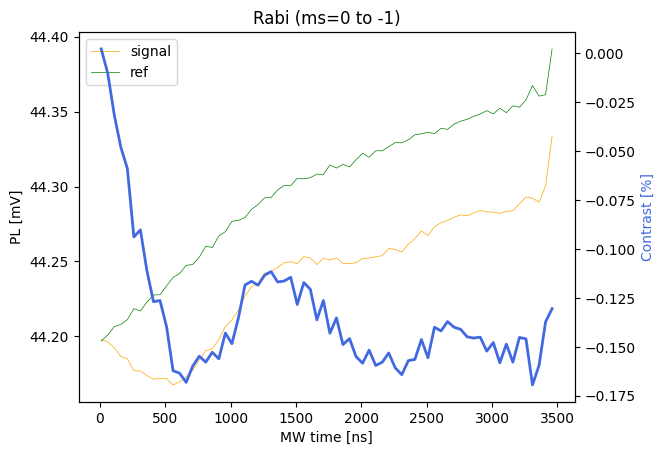

In [26]:
import matplotlib.pyplot as plt
mw_dur = rabi.dataset["mw_dur"]

signal_av = rabi.dataset["sig_mw"]
background_av = rabi.dataset["sig_nomw"]
contrast = (signal_av-background_av)/background_av
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# mw_dur = np.arange(len(signal_av))
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')

# idxend = 200
ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

Fitted Parameters:
A (Amplitude): 0.073%
f (Frequency): 0.59 MHz
phi (Phase): 2.5 rad
tau (Gaussian decay for sine): 1540.8 ns
B (Background amplitude): 0.102 %
tau_b (Gaussian decay for background): 719.2 ns
C (Flat background offset): -0.148 %


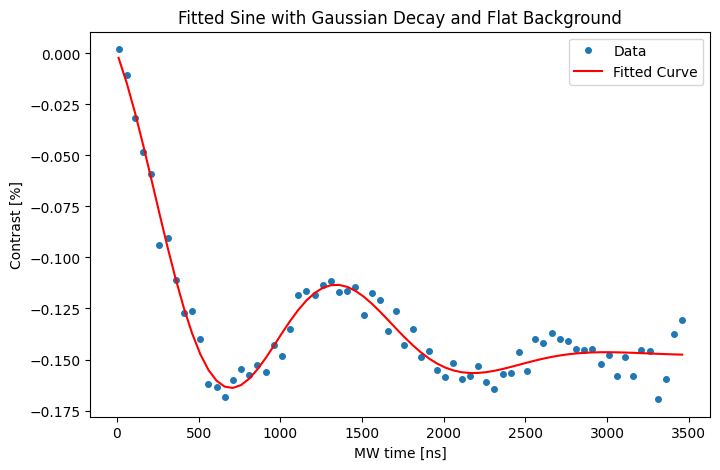

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

BOUNDS_SINE_GAUSSIAN_DECAY = (
    [-np.inf, 0, -np.pi, 0, -np.inf, 0, -np.inf],
    [np.inf, np.inf, np.pi, np.inf, np.inf, np.inf, np.inf],
)

# Define the model: Sine with Gaussian decay and flat background
def model_sine_gaussian_decay(t, A, f, phi, tau, B, tau_b, C):
    """
    Sine with Gaussian decay and a flat background.
    :param t: Time (mw_dur)
    :param A: Amplitude of the sine wave
    :param f: Frequency of the sine wave
    :param phi: Phase of the sine wave
    :param tau: Gaussian decay constant for the sine wave
    :param B: Background amplitude
    :param tau_b: Gaussian decay constant for the background
    :param C: Flat background offset
    """
    return (
        A * np.sin(2 * np.pi * f * t + phi) * np.exp(-((t / tau) ** 2))
        + B * np.exp(-((t / tau_b) ** 2))
        + C
    )


# Parameter estimation method
def estimator_sine_gassian_decay(t, y):
    """
    Estimate initial parameters for the sine with Gaussian decay fit.
    :param t: Independent variable (e.g., mw_dur)
    :param y: Dependent variable (e.g., contrast)
    :return: Initial guesses for A, f, phi, tau, B, tau_b, C
    """
    # Estimate amplitude (A) as half the range of y
    A = (np.max(y) - np.min(y)) / 2

    # Estimate frequency (f) using FFT
    fft_freqs = np.fft.fftfreq(len(t), d=(t[1] - t[0]))
    fft_magnitude = np.abs(np.fft.fft(y - np.mean(y)))  # Remove DC component
    f = np.abs(fft_freqs[np.argmax(fft_magnitude[1:]) + 1])  # Dominant frequency

    # Phase (phi) can start at zero
    phi = 0

    # Estimate tau as a fraction of the total duration
    tau = (t[-1] - t[0]) / 3

    # Estimate background amplitude (B) and decay (tau_b)
    B = np.mean(y[y < np.median(y)])  # Lower half average as baseline
    tau_b = tau * 2  # Assume background decays slower than sine

    # Flat background offset (C) as the mean of the data
    C = np.mean(y)

    return [A, f, phi, np.abs(tau), B, np.abs(tau_b), C]

# Fit the data
def fit_sine_gaussian_decay(tt, yy):
    # Estimate initial parameters
    initial_guess = estimator_sine_gassian_decay(tt, yy)

    # Curve fitting
    params, covariance = curve_fit(
        model_sine_gaussian_decay,
        tt,
        yy,
        p0=initial_guess,
        bounds=BOUNDS_SINE_GAUSSIAN_DECAY,
    )

    return params, np.sqrt(np.diag(covariance))  # Return parameters and uncertainties


# Example usage
# Assuming mw_dur and contrast are your data arrays
params, uncertainties = fit_sine_gaussian_decay(mw_dur, contrast)

# Extract parameters
A, f, phi, tau, B, tau_b, C = params
print("Fitted Parameters:")
print(f"A (Amplitude): {A*100.0:.3f}%")
print(f"f (Frequency): {f*1e3:.2f} MHz")
print(f"phi (Phase): {phi:.1f} rad")
print(f"tau (Gaussian decay for sine): {tau:.1f} ns")
print(f"B (Background amplitude): {B*100.0:.3f} %")
print(f"tau_b (Gaussian decay for background): {tau_b:.1f} ns")
print(f"C (Flat background offset): {C*100.0:.3f} %")

# Generate fitted curve
fitted_contrast = model_sine_gaussian_decay(mw_dur, *params)

# Plot the original data and fitted curve
plt.figure(figsize=(8, 5))
plt.plot(mw_dur, contrast * 100.0, "o", label="Data", markersize=4)
plt.plot(mw_dur, fitted_contrast*100.0, "-", label="Fitted Curve", color="red")
plt.xlabel("MW time [ns]")
plt.ylabel("Contrast [%]")
plt.title("Fitted Sine with Gaussian Decay and Flat Background")
plt.legend()
plt.show()


In [55]:
print(params)

[ 7.31220714e-04  5.88768238e-04  2.47215447e+00  1.54081029e+03
  1.02436466e-03  7.19224733e+02 -1.47814081e-03]
